In [93]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
d = 'cuda'


In [94]:
words = open('names.txt', 'r').read().split()
len(words)


32033

In [95]:


chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [96]:
def build_dataset(words):
    X,Y = [],[]

    for w in words:
        word = ['.'] + list(w) + ['.']
        chs = [stoi[k] for k in word]
        

        for i in range(len(chs)-1):
            x = torch.tensor(chs[:i+1],device=d)
            y = torch.tensor(chs[i+1],device=d)
            # print(x,'-->',y)
            
            X.append(x)
            Y.append(y)
            
    print(len(X), len(Y))
    return X,Y

In [ ]:

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

random.seed(42)
random.shuffle(words)

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xtst, ytst = build_dataset(words[n2:])

In [3]:
class Embedding:

    def __init__(self, n_emb, emb_dim):
        self.weight = torch.randn((n_emb, emb_dim), device=d)

    def __call__(self,x):
        self.out = [self.weight[i] for i in x]
        return self.out

    def parameters(self):
        return [self.weight] 

#########################################################################################

class Sequential:
    
    def __init__(self, layers):
        self.layers =layers

    def __call__(self, x): 
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


#########################################################################################

class RNN:

    def __init__(self, _in, _out, hd_st, return_sequence=False):
        self.return_sequence = return_sequence
        self.wxh = torch.randn((_in, hd_st), device=d) / _in ** 0.5
        self.whh = torch.randn((hd_st, hd_st), device=d) / hd_st ** 0.5
        self.bh = torch.randn(hd_st, device=d)
        self.ht = torch.zeros(hd_st, device=d)
        self.wy = torch.randn((hd_st, _out), device=d) / hd_st ** 0.5
        self.by = torch.randn(_out, device=d)

    def __call__(self, x):
        # x: List of sequences
        outputs = []
        for seq in x:
            self.ht = torch.zeros_like(self.ht)
            hiddens = []
            for emb in seq:
                h = emb @ self.wxh + self.ht @ self.whh + self.bh
                self.ht = h
                hiddens.append(h)
            if self.return_sequence:
                # Apply output layer to each time step
                yt_seq = [h @ self.wy + self.by for h in hiddens]
                outputs.append(yt_seq)
            else:
                # Only last hidden state → one output vector
                yt = self.ht @ self.wy + self.by
                outputs.append(yt)
        if self.return_sequence:
            return outputs  # List[List[Tensor]]
        else:
            return torch.stack(outputs)

    def parameters(self):
        return [self.wxh, self.whh, self.bh, self.wy, self.by]



class Tanh:
    def __call__(self, x):
        if isinstance(x, list):
            return [[torch.tanh(item) for item in seq] for seq in x]
        else:
            return torch.tanh(x)

    def parameters(self):
        return []



In [107]:

emb_d = 30
hd_st = 200
_out = 27



model = Sequential([
    Embedding(vocab_size, emb_d),
    RNN(emb_d, vocab_size*3, hd_st, return_sequence=True),
    RNN(vocab_size*3, vocab_size*2, hd_st, return_sequence=True),
    Tanh(),
    RNN(vocab_size*2, vocab_size*2, hd_st, return_sequence=True),
    Tanh(),
    RNN(vocab_size*2, vocab_size, hd_st, return_sequence=False),  # last one gives final logits
])



parameters = model.parameters()

for p in parameters:
    p.requires_grad = True

            
print(sum(p.nelement() for p in parameters))

max_steps = 20000
batch_size = 32
lossi = []


248826


In [108]:



for i in range(max_steps):

    ix = torch.randint(0, len(xtr), (batch_size,))
    Xb = [xtr[i] for i in ix]
    Yb = torch.tensor([ytr[i] for i in ix], device=d)


    # print("Max index in batch:", max([max(seq) for seq in Xb]))
    # print("Min index in batch:", min([min(seq) for seq in Xb]))
    # print("Embedding weight shape:", model.layers[0].weight.shape)

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
    loss.backward()

    if i < 10000:
        lr = 0.01
    else:
        lr = 0.001

    for p in parameters:
        p.data -= p.grad * lr

    if i % 1 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())




      0/  20000: 7.200558
      1/  20000: 5.376704
      2/  20000: 4.434051
      3/  20000: 3.929996
      4/  20000: 2.894036
      5/  20000: 3.459594
      6/  20000: 3.160483
      7/  20000: 3.456720
      8/  20000: 3.182250
      9/  20000: 3.408446
     10/  20000: 3.490983
     11/  20000: 3.528211
     12/  20000: 2.623427
     13/  20000: 3.829935
     14/  20000: 4.081508
     15/  20000: 3.461456
     16/  20000: 3.281491
     17/  20000: 3.090570
     18/  20000: 2.850780
     19/  20000: 2.666589
     20/  20000: 3.024327
     21/  20000: 3.509625
     22/  20000: 3.269009
     23/  20000: 2.957803
     24/  20000: 2.552074
     25/  20000: 2.550624
     26/  20000: 3.061432
     27/  20000: 2.989086
     28/  20000: 2.434391
     29/  20000: 2.989277
     30/  20000: 2.738046
     31/  20000: 3.207862
     32/  20000: 2.697855
     33/  20000: 2.770548
     34/  20000: 2.858823
     35/  20000: 2.875501
     36/  20000: 3.362077
     37/  20000: 2.625993
     38/  20

In [109]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (xtr, ytr),
        'val': (xdev, ydev),
        'test': (xtst, ytst)
    }[split]

    # move everything to the right device
    y = torch.tensor(y, device=d)  # now it's a proper tensor
    x = [seq.to(d) for seq in x]   # move each sequence

    logits = model(x)  # should return [B, vocab_size]
    loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item():.4f}")
    return loss.item()

split_loss('test')
split_loss('val')
split_loss('train')

test: 2.2206
val: 2.2209
train: 2.2045


2.204470157623291

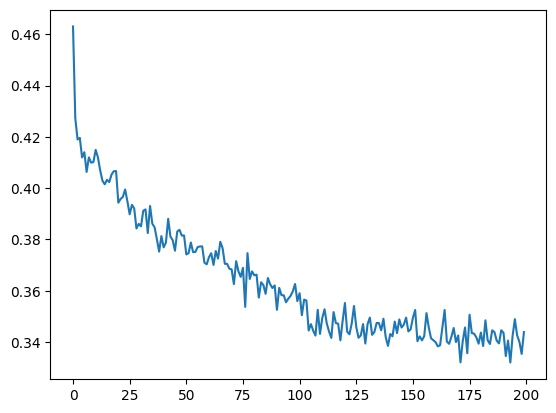

In [128]:
plt.plot(torch.tensor(lossi).view(-1,100).mean(1))

In [133]:

# Generate `num_names` samples
num_names = 20

for _ in range(num_names):
    context = [0]  # Start with '.' token index
    out = []

    while True:
        # Prepare input (list of a tensor)
        x = [torch.tensor(context, device=d)]

        # Forward pass through model
        logits = model(x)  # [1, vocab_size]

        # Convert logits to probabilities
        probs = F.softmax(logits, dim=1) ** 1.8  # [1, vocab_size]

        # Sample the next index
        ix = torch.multinomial(probs, num_samples=1).item()

        # Add to context
        context.append(ix)
        out.append(ix)

        # If end token, stop
        if ix == 0:
            break

    # Convert from indices to characters
    name = ''.join(itos[i] for i in out[:-1])  # exclude final '.'
    print(name)


senah
alli
brandon
samera
nile
riri
brenny
elin
zaiven
elleste
samvir
anian
leela
laigen
carbel
laree
khay
sane
ajele
amaria
